<a href="https://colab.research.google.com/github/treyra/CS155_miniproject3/blob/main/homework_hmm_sonnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np

In [12]:
# mount drive
# load data by line and data by sonnet
from google.colab import drive
drive.mount('./drive',force_remount=True)

Mounted at ./drive


In [13]:
# load the data - for now from drive until we have repo
# open existing text file
data_sonnet = np.genfromtxt('/content/drive/My Drive/CS155_miniproject_3/data_sonnet.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1')
data_line = np.genfromtxt('/content/drive/My Drive/CS155_miniproject_3/data_line.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1')

In [14]:
# homework HMM code
import os
import re
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation

In [15]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        ###
        A = self.A
        O = self.O
        A_start = self.A_start
        A1 = np.array(A)
        A1_start = np.array(A_start)
        B1 = np.array(O)

        prob = np.zeros((self.L,M))
        seq = np.zeros((self.L,M))
        
        prob[:,0] = A1_start * B1[:,x[0]]
        seq[:,0] = 0

        # update probabilities and sequences 
        for i in range(1,M):
          prob[:,i]=np.max(prob[:,i-1]*A1.T*B1[:,x[i]].reshape(-1,1),1)
          seq[:,i]=np.argmax(prob[:,i-1]*A1.T,1)

        x_o = np.empty(M,'B')
        x_o[-1] = np.argmax(prob[:,M-1])
        for i in reversed(range(1,M)):
          x_o[i-1]=seq[x_o[i],i]

        x_o2 = x_o.tolist()
        max_seq = ''.join([str(item) for item in x_o2])
        return max_seq
        ###

        # max_seq = ''
        # return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        ###
        L = self.L
        D = self.D
        A = self.A
        O = self.O
        A_start = self.A_start
        A1 = np.array(A)
        A1_start = np.array(A_start)
        O1 = np.array(O)
        x1 = np.array(x)

        alphas = np.zeros((M,self.L))
        alphas[0,:] = A1_start * O1[:,x1[0]]

        for idx1 in range(1,x1.shape[0]):
          for idx2 in range(A1.shape[0]):
            alphas[idx1,idx2]=alphas[idx1-1].dot(A1[:,idx2])*O1[idx2,x1[idx1]]

        if normalize:
          for idx1 in range(len(alphas)):
            if np.sum(np.abs(alphas[idx1,:])) != 0:
              alphas[idx1,:] = alphas[idx1,:]/np.sum(np.abs(alphas[idx1,:]))
        ###

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        ###
        A = self.A
        L = self.L
        D = self.D
        O = self.O
        A1 = np.array(A)
        O1 = np.array(O)
        x1 = np.array(x)
        betas = np.zeros((M+1,L))
        betas[-1,:] = 1
        # update betas
        for idx1 in range(M-1,-1,-1):
          for idx2 in range(L):
            betas[idx1,idx2]= (betas[idx1+1,:]*O1[:,x1[idx1]]).dot(A1[idx2,:])

        if normalize:
          for idx1 in range(0,len(betas)):
            if np.sum(np.abs(betas[idx1,:])) != 0:
              betas[idx1,:] = betas[idx1,:]/np.sum(np.abs(betas[idx1,:]))
        ###

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.

        ###
        A1 = np.array(self.A)

        for idx1 in range(len(A1)):
          for idx2 in range(len(A1[0])):
            sum_a = 0
            sum_b = 0
            N = len(Y)
            for idx3 in range(0,N):
              Mj = len(Y[idx3])
              for idx4 in range(0,Mj-1):
                p1 = (Y[idx3][idx4+1] == idx2)
                p2 = (Y[idx3][idx4]== idx1)
                if p1==1 and p2==1:
                  sum_a+=1
                p3 = (Y[idx3][idx4]==idx1)
                if p3==1:
                  sum_b+=1
                if sum_b == 0:
                  self.A[idx1][idx2] = 0
                else:
                  self.A[idx1][idx2] = sum_a/sum_b

        # Calculate each element of O using the M-step formulas.
        O1 = np.array(self.O)

        for z in range(len(O1)):
          for w in range(len(O1[0])):
            sum_a = 0
            sum_b = 0
            N = len(Y)
            for idx3 in range(0,N):
              Mj = len(X[idx3])
              for idx4 in range(0,Mj):
                p1 = (X[idx3][idx4]==w)
                p2 = (Y[idx3][idx4]==z)
                if p1 ==1 & p2==1:
                  sum_a+=1
                p3 = (Y[idx3][idx4]==z)
                if p3 == 1:
                  sum_b+=1
                if sum_b == 0:
                  self.O[z][w] = 0
                else:
                  self.O[z][w] = sum_a/sum_b
              
        ###

        pass


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.
            N_iters:    The number of iterations to train on.
        '''

        ###
        for _ in range(N_iters):
          L = self.L
          D = self.D
          Atop = np.zeros((L, L))
          Abot = np.zeros((L, L))
          Otop = np.zeros((L, D))
          Obot = np.zeros((L, D))
           
          # loop
          for idx1 in range(len(X)): 
            alphas = self.forward(X[idx1], True)
            betas = self.backward(X[idx1], True)
            P1 = np.zeros((len(alphas), len(alphas[0])))
            # get first marginal
            for b in range(0, len(alphas) ):
              for c in range(L):
                sum1 = 0
                sum2 = 0
                sum1 = alphas[b][:].dot(betas[b+1][:])
                if sum1 != 0:
                  P1[b][c] = alphas[b][c]*betas[b+1][c]/sum1
            # get second marginal
            L = self.L
            P2 = np.zeros((len(X[idx1]), L, L))
            A1 = np.array(self.A)
            O1 = np.array(self.O)
            for d in range(1, len(X[idx1])):
              for e in range(L):              
                for f in range(L): 
                  sum2 = 0
                  sum3 = 0
                  sum4 = 0
                  sum4 = sum((np.array(alphas[d - 1][0:L]).dot((A1[0:L, 0:L])))*(O1[0:L, X[idx1][d]]*betas[d + 1][0:L]))
                  if sum4 != 0:
                    P2[d, e, f] = alphas[d - 1][e]*self.A[e][f]*self.O[f][X[idx1][d]]*betas[d + 1][f]/sum4
            for g in range(L):              
              for h in range(L):  
                for i in range(0, len(X[idx1])-1):
                  Abot[g][h] += P1[i][g]
            for j in range(L):              
              for k in range(L):  
                for l in range(0, len(X[idx1])):
                  Atop[j][k] += P2[l][j][k]
            for m in range(D):  
              for n in range(0, len(X[idx1])):
                Otop[:, m] += P1[n, :]*(X[idx1][n] == m)
            for o in range(D):
              Obot[:, o] += np.sum(np.array(P1), axis = 0) 
                        
          # compute new A and O
          A = np.divide(Atop, Abot)
          O = np.divide(Otop, Obot)
          # save them
          self.A = A
          self.O = O
        ###
        pass


    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        emission = []
        states = []

        ###
        A = self.A
        O = self.O
        L = self.L
        O1 = np.array(O)
        A1 = np.array(A)
        # set first state and emission
        states.append(np.random.randint(0,L))
        emission.append(np.random.choice(self.D,None,True,O1[states[0],:]))
        # now go through
        for idx in range(M-1):
          states.append(np.random.choice(self.L,None,True,A1[states[idx],:]))
          emission.append(np.random.choice(self.D,None,True,O1[states[idx+1],:]))
        ###

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters,rng=np.random.RandomState(1)):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

In [16]:
########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim


In [17]:
class Utility:
    '''
    Utility for the problem files.
    '''

    def __init__():
        pass

    @staticmethod
    def load_sequence(n):
        '''
        Load the file 'sequence_data<n>.txt' for a given n.
        Arguments:
            n:          Sequence index.
        Returns:
            A:          The transition matrix.
            O:          The observation matrix.
            seqs:       Input sequences.
        '''
        A = []
        O = []
        seqs = []

        # For each file:
        with urllib.request.urlopen(f'https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/psets/set6/data/sequence_data{n}.txt') as f:
            # Read the parameters.
            L, D = [int(x) for x in f.readline().decode('utf-8').strip().split('\t')]

            # Read the transition matrix.
            for i in range(L):
                A.append([float(x) for x in f.readline().decode('utf-8').strip().split('\t')])

            # Read the observation matrix.
            for i in range(L):
                O.append([float(x) for x in f.readline().decode('utf-8').strip().split('\t')])

            # The rest of the file consists of sequences.
            while True:
                seq = f.readline().decode('utf-8').strip()
                if seq == '':
                    break
                seqs.append([int(x) for x in seq])

        return A, O, seqs

    @staticmethod
    def load_ron():
        '''
        Loads the file 'ron.txt'.
        Returns:
            moods:      Sequnces of states, i.e. a list of lists.
                        Each sequence represents half a year of data.
            mood_map:   A hash map that maps each state to an integer.
            genres:     Sequences of observations, i.e. a list of lists.
                        Each sequence represents half a year of data.
            genre_map:  A hash map that maps each observation to an integer.
        '''
        moods = []
        mood_map = {}
        genres = []
        genre_map = {}
        mood_counter = 0
        genre_counter = 0

        with urllib.request.urlopen("https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/psets/set6/data/ron.txt") as f:
            mood_seq = []
            genre_seq = []

            while True:
                line = f.readline().decode('utf-8').strip()

                if line == '' or line == '-':
                    # A half year has passed. Add the current sequence to
                    # the list of sequences.
                    moods.append(mood_seq)
                    genres.append(genre_seq)
                    # Start new sequences.
                    mood_seq = []
                    genre_seq = []
                
                if line == '':
                    break
                elif line == '-':
                    continue
                
                mood, genre = line.split()
                
                # Add new moods to the mood state hash map.
                if mood not in mood_map:
                    mood_map[mood] = mood_counter
                    mood_counter += 1

                mood_seq.append(mood_map[mood])

                # Add new genres to the genre observation hash map.
                if genre not in genre_map:
                    genre_map[genre] = genre_counter
                    genre_counter += 1

                # Convert the genre into an integer.
                genre_seq.append(genre_map[genre])

        return moods, mood_map, genres, genre_map

    @staticmethod
    def load_ron_hidden():
        '''
        Loads the file 'ron.txt' and hides the states.
        Returns:
            genres:     The observations.
            genre_map:  A hash map that maps each observation to an integer.
        '''
        moods, mood_map, genres, genre_map = Utility.load_ron()

        return genres, genre_map

Now implement on sonnet data

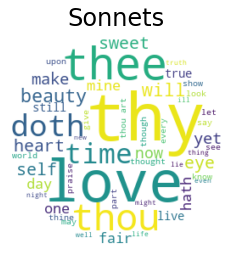

In [18]:
# load sonnet
data_sonnet = urllib.request.urlopen('https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/data_sonnet.txt').read().decode('utf-8')
data_line = urllib.request.urlopen('https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/data_line.txt').read().decode('utf-8')

wordcloud = text_to_wordcloud(data_sonnet, title='Sonnets')

In [19]:
# obs, obs_map = parse_observations(data_sonnet)
# hmm8 = unsupervised_HMM(obs, 10, 100)

In [20]:
# print('Sample Sentence:\n====================')
# print(sample_sentence(hmm8, obs_map, n_words=25))

In [21]:
# read data in per line
with open ("/content/drive/My Drive/CS155_miniproject_3/data_sonnet.txt", "r") as f:
  data_sonnet=f.readlines()

In [22]:
# split line into separate words
import re
for i in range(len(data_sonnet)):
  data_sonnet[i] = re.findall(r"[\w']+|[.,?;]", data_sonnet[i])

In [23]:
# create obs map
count = 0
obs = []
obs_map = {}

for line in data_sonnet:
  obs_line = []
  for word in line:
    if word not in obs_map:
      # add new words to the map
      obs_map[word] = count
      count += 1
    # add the encoded words to the line map
    obs_line.append(obs_map[word])
      
    # add the encoded sequence
  obs.append(obs_line)

In [ ]:
# train small hmm
hmm2 = unsupervised_HMM(obs, 2, 20)

In [ ]:
# generate sample sentences
print('Sample Sentence:\n====================')
print(sample_sentence(hmm2, obs_map, n_words=25))

In [ ]:
## Visualize states
wordclouds = states_to_wordclouds(hmm2, obs_map,10)

Make syllable dictionary

In [ ]:
!wget https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/Syllable_dictionary.txt

In [ ]:
import re
with open('Syllable_dictionary.txt', "r") as f:
  syl_data = f.readlines()
  #dict_exp = dict(re.findall(r'(\S+)\s+(.+)', f.read()))

In [ ]:
# remove all ' or " and \n
# remove punctuation
to_remove = ['-', "'"]
for k in range(len(to_remove)):
  for i in range(len(syl_data)):
    syl_data[i] = ''.join([j for j in syl_data[i] if j not in to_remove])
#print(syl_data[0])
for i in range(len(syl_data)):
  syl_data[i] = syl_data[i].replace('\n', '')
#print(syl_data[0])
# split the lines into words
for i in range(len(syl_data)):
  syl_data[i] = re.findall(r"[\w']+|[.,?;]", syl_data[i])
#print(syl_data[0])
# make syl_data a dictionary
syl_dict = dict()
for line in syl_data:
  #print(line)
  #import pdb; pdb.set_trace()
  syl_dict.update({line[0]: [line[i] for i in range(1, len(line))]})


In [ ]:
# save the dictionary as pkl file
import pickle
a_file = open("SylDict.pkl", "wb")
pickle.dump(syl_dict, a_file)
a_file.close()

# load the dict from pickle file

Generate random sonnet

In [ ]:
# now generate a random sonnet
emission = []
states = []

L = hmm2.L
D = hmm2.D     
O = np.array(hmm2.O)
A = np.array(hmm2.A)
obs_map_r = obs_map_reverser(obs_map)

# make sure we have 14 lines
for i in range(0,14):
  # each line with 10 syllables
  emission = []
  states = []
  k = 0
  # Initial state
  states.append(np.random.randint(0,L))
  emission.append(np.random.choice(D,None, True, O[states[0],:]))
  syl_count= SyllDict[obs_map_r[emission[0]]]
  if len(syl_count)>1:
    # check to use the one not at the end or just randomly
    if syl_count[0][0]!='E':
      syl_count = syl_count[0][0]
  k+=syl_count
  while k<10:
    # generate next word
    states.append(np.random.choice(L,None, True, A[states[i-1],:]))
    emission.append(np.random.choice(D,None, True, O[states[i],:]))
    syl_count= SyllDict[obs_map_r[emission[0]]]
    if len(syl_count)>1:
      end_count = [x for x in syl_count if x.startswith('E')]
      #if len(end_count) == 1:
      if k + end_count > 10:
        # pick this word and save sentence
        syl_count=end_count
      # check to use the correct one
      else:
        for s in syl_count:
          if s[0]!='E':
            syl_count = s
    k+=syl_count
  sentence = [obs_map_r[i] for i in emission]
  print(' '.join(sentence).capitalize())
  # break the line after 4/8/12 lines
  if (i == 3 or i == 7 or i == 11):
    print('\n')